# SARIMA AQI Forecasting (Delhi)
Goal: prepare Delhi AQI, inspect seasonality, fit a SARIMAX model, and forecast future months.

**Workflow**
1) Setup and load daily AQI data
2) Keep relevant columns, focus on Delhi, backfill gaps
3) Resample monthly and plot AQI trend
4) Seasonal decomposition check
5) Fit SARIMAX, evaluate train/test RMSE, forecast ahead
6) Optional: grid-search hyperparameters

In [1]:
#Importing the required libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML,display

warnings.filterwarnings("ignore")

## 1. Setup
Import analysis and plotting libraries; suppress benign warnings.

In [2]:
#Read the daily city-wise data
df= pd.read_csv("./datasets/city_day.csv",parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])

## 2. Load daily data
Read city-level AQI and parse dates.

In [3]:
#Keeping only the columns needed
df=df[['City','Date','AQI']]

### 2.1 Keep relevant columns
Retain City/Date/AQI for modeling.

In [4]:
#Filtering the dataframe to keep the data for the city of Delhi only
delhi = df[df['City'] == 'Delhi']
delhi.drop(['City'],axis=1,inplace = True)
delhi.set_index('Date', inplace = True)


## 3. Focus on Delhi
Filter for Delhi, set Date index, and backfill missing AQI.

In [5]:
delhi

,AQI
Date,
2015-01-01,472.0
2015-01-02,454.0
2015-01-03,143.0
2015-01-04,319.0
2015-01-05,325.0
...,...
2020-06-27,112.0
2020-06-28,196.0
2020-06-29,233.0


In [6]:
#Fill NULL DATA
delhi['AQI'] = delhi['AQI'].bfill()

### 3.1 Fill gaps
Backfill AQI to handle missing values before resampling.

In [7]:
#Taking monthly average
delhi=delhi.astype('float64')
delhi=delhi.resample(rule='MS').mean()

### 3.2 Resample monthly
Aggregate to month-start averages for smoother modeling.

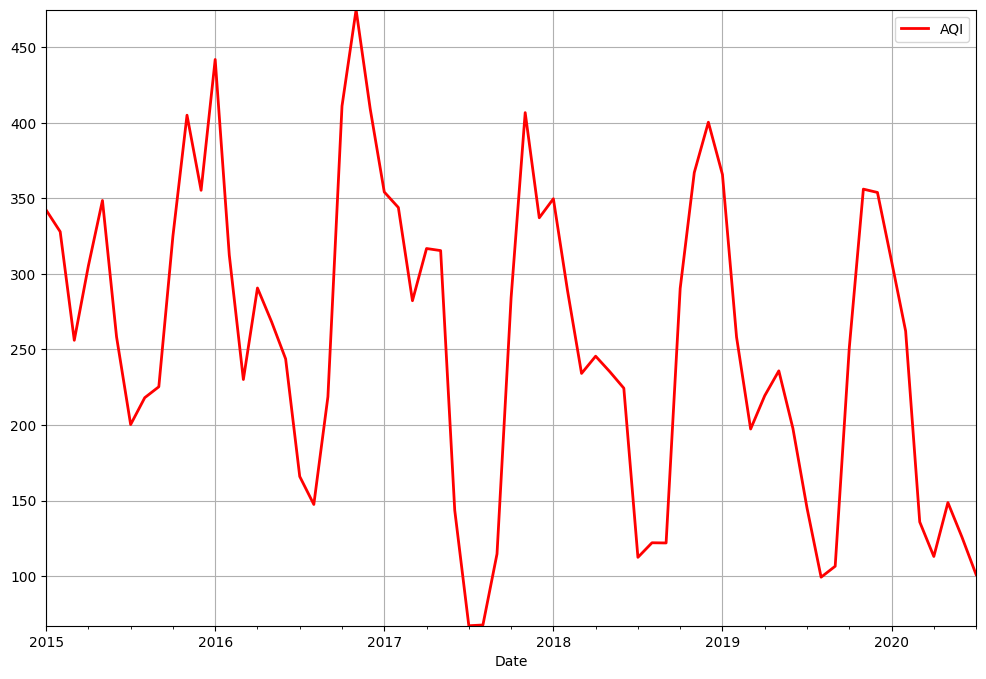

In [8]:
ax=delhi[['AQI']].plot(figsize=(12,8),grid=True,lw=2,color='Red')
ax.autoscale(enable=True, axis='both', tight=True)

## 4. Visualize monthly AQI
Plot the resampled AQI to inspect trend and scale.

## 5. Seasonality check
Decompose the monthly series (multiplicative) to view trend/seasonal/residual components.

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

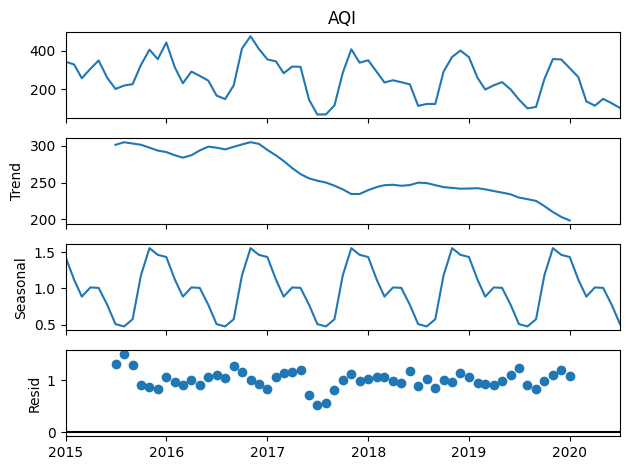

In [10]:
delhi_AQI=delhi['AQI']
result=seasonal_decompose(delhi_AQI,model='multiplicative')
result.plot();

## 6. SARIMAX model
Split train/test, fit a seasonal model, evaluate, and forecast.

In [11]:
#Importing the SARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [12]:
len(delhi_AQI)

67

In [13]:
#Splitting the training and testing dataset
train=delhi_AQI[:48]
test=delhi_AQI[48:61]

### 6.1 Train/test split
First 48 months for training, remaining for testing.

In [14]:
#Defining our model and fitting on the training data
model=SARIMAX(train,order=(0,1,3),seasonal_order=(0,1,1,12))
results=model.fit()
results.summary()

c:\Users\srija\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  AQI   No. Observations:                   48
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -185.444
Date:                              Sat, 06 Dec 2025   AIC                            380.888
Time:                                      22:08:17   BIC                            388.665
Sample:                                  01-01-2015   HQIC                           383.573
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5591      8.143     -0.069      0.945     -16.519      15.401
ma.L2         -0.0814      3.616     -0.022      0.982      -7.169       7.006
ma.L3         -0.3558      3.058     -0.116      0.907      -6.349       5.638
ma.S.L12      -0.9978    121.732     -0.008      0.993    -239.588     237.593
sigma2      1325.9019   1.61e+05      0.008      0.993   -3.13e+05    3.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.43   Prob(JB):                         0.89
Heteroskedasticity (H):               0.54   Skew:                             0.20
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 6.2 Fit SARIMAX (0,1,3)x(0,1,1,12)
Baseline seasonal model on training data.

In [15]:
#Predicting on our train and test dataset
train_predictions = results.predict(start=1, end=48, typ='levels').rename('Predictions')
test_predictions = results.predict(start=48, end=60, typ='levels').rename('Predictions')

### 6.3 Predict train/test
Generate in-sample and holdout predictions.

<Axes: xlabel='Date'>

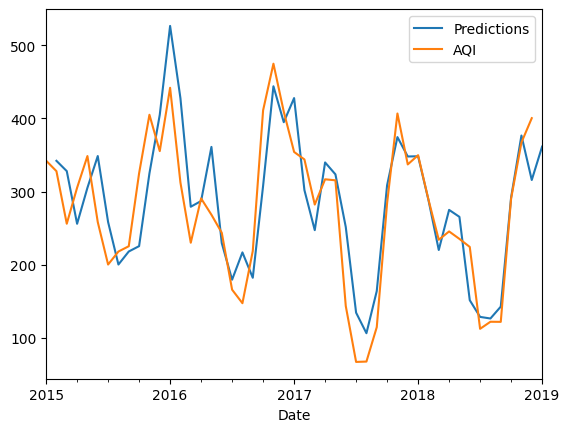

In [16]:
#Plotting the train predictions to see the fit of the model
train_predictions.plot(legend=True)
train.plot(legend=True)

In [17]:
#Calculating the RMSE value on the training dataset 
RMSE=np.sqrt(mean_squared_error(train_predictions,train))
print('RMSE = ',RMSE)
print('Mean AQI',train.mean())

RMSE =  66.39492659605766
Mean AQI 275.1711046334552


### 6.4 Train RMSE
Assess fit quality on training window.

<Axes: xlabel='Date'>

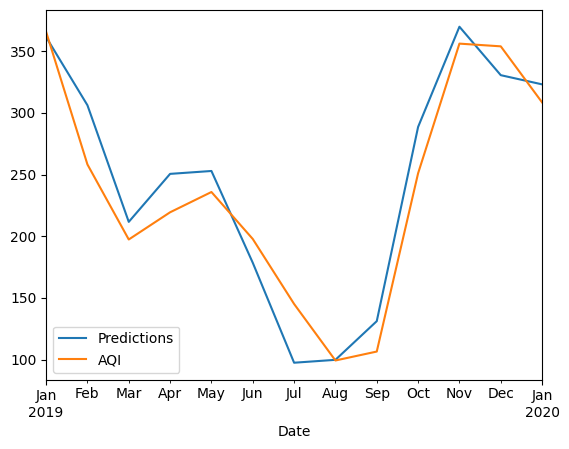

In [18]:
#Plotting the test predictions to see how well our model generalized
test_predictions.plot(legend=True)
test.plot(legend=True)

In [19]:
#Calculating the RMSE value on the testing dataset 
RMSE=np.sqrt(mean_squared_error(test_predictions,test))
print('RMSE = ',RMSE)
print('Mean AQI',test.mean())

RMSE =  26.876745763265692
Mean AQI 238.0504608294931


### 6.5 Test RMSE
Evaluate generalization on the holdout months.

<Axes: xlabel='Date'>

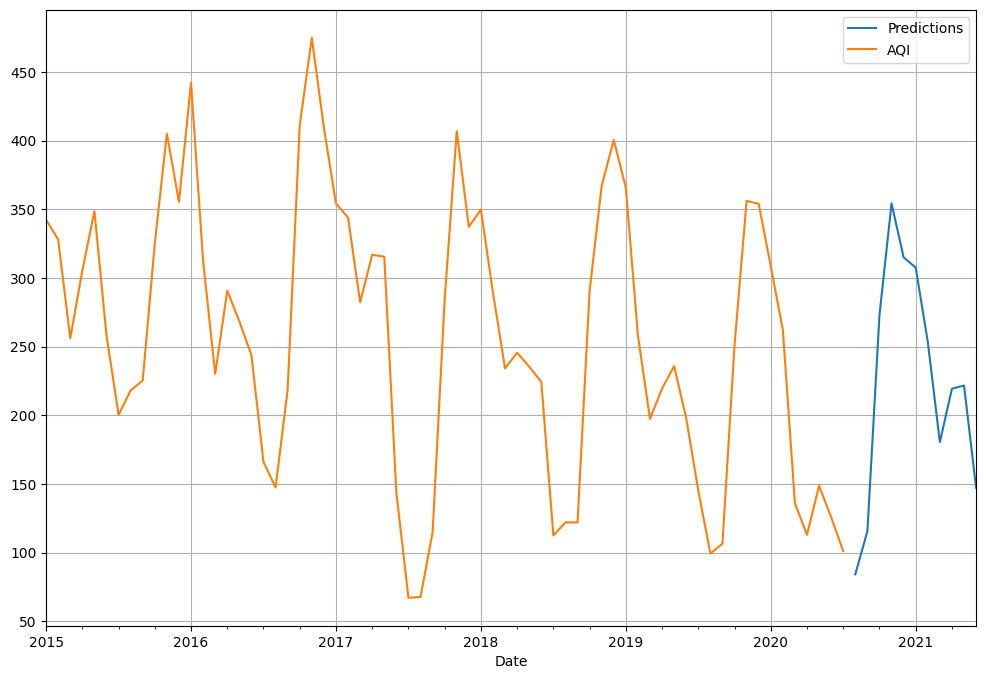

In [20]:
#Obtaining predicted values:
future_predictions = results.predict(start=67, end=77, typ='levels').rename('Predictions')

#Plotting predicted values against the true values:
future_predictions.plot(legend=True)
delhi_AQI.plot(legend=True,figsize=(12,8),grid=True)

### 6.6 Forecast next months
Project future AQI and overlay with history.

## 7. Grid search (optional)
Small SARIMA grid to compare RMSE across parameter sets.

In [21]:
def grid_search(p,d,q,P,D,Q,m,train,test):
    
    column_names = ['p','d','q','P','D','Q','m','RMSE_train','RMSE_test']
    df = pd.DataFrame(columns = column_names)
    results_list = []

    for p1 in p:
        for p2 in d:
            for p3 in q:
                for p4 in P:
                    for p5 in D:
                        for p6 in Q:
                            for p7 in m:
                                
                                
                                model=SARIMAX(train,order=(p1,p2,p3),seasonal_order=(p4,p5,p6,p7))
                                try:
                                    results=model.fit()
                                except Exception as e:
                                    print("Passing on : " + str(p1) + " " + str(p2) + " " + str(p3) + " " + str(p4) + " " + str(p5) + " " + str(p6) + " " + str(p7) + " Error: " + str(e))
                                    pass
                                print("Fitting on : " + str(p1) + " " + str(p2) + " " + str(p3) + " " + str(p4) + " " + str(p5) + " " + str(p6) + " " + str(p7))
                                #results.summary()
                                #Predicting on our train and test dataset
                                train_predictions = results.predict(start=1, end=48, typ='levels').rename('Predictions')
                                test_predictions = results.predict(start=48, end=60, typ='levels').rename('Predictions')
                                
                                #Calculating the RMSE value on the training dataset 
                                RMSE_train = np.sqrt(mean_squared_error(train_predictions,train))
                                #Calculating the RMSE value on the testing dataset 
                                RMSE_test=np.sqrt(mean_squared_error(test_predictions,test))
                                
                                #Add results to list
                                results_list.append({'p':p1, 'd':p2,'q':p3,
                                                'P':p4,'D':p5,'Q':p6,'m':p7,
                                                'RMSE_train' : RMSE_train, 'RMSE_test' : RMSE_test})
                                
                                # Create temporary dataframe and concatenate
                                df = pd.concat([df, pd.DataFrame([results_list[-1]])], ignore_index=True)
                                print(df.tail(1))
                                
                                
                                
    return df

In [22]:
train=delhi_AQI[:48]
test=delhi_AQI[48:61]

# Reduced parameter grid for faster execution
p = [0, 1, 2]
d = [1]
q = [1, 2]
P = [0, 1]
D = [1]
Q = [1]
m = [12]

table = grid_search(p,d,q,P,D,Q,m,train,test)

Fitting on : 0 1 1 0 1 1 12
   p  d  q  P  D  Q   m  RMSE_train  RMSE_test
0  0  1  1  0  1  1  12   61.292043  58.447843
Fitting on : 0 1 1 1 1 1 12
   p  d  q  P  D  Q   m  RMSE_train  RMSE_test
1  0  1  1  1  1  1  12   60.270597  67.295196
Fitting on : 0 1 1 1 1 1 12
   p  d  q  P  D  Q   m  RMSE_train  RMSE_test
1  0  1  1  1  1  1  12   60.270597  67.295196
Fitting on : 0 1 2 0 1 1 12
   p  d  q  P  D  Q   m  RMSE_train  RMSE_test
2  0  1  2  0  1  1  12   63.543553  42.223336
Fitting on : 0 1 2 0 1 1 12
   p  d  q  P  D  Q   m  RMSE_train  RMSE_test
2  0  1  2  0  1  1  12   63.543553  42.223336
Fitting on : 0 1 2 1 1 1 12
   p  d  q  P  D  Q   m  RMSE_train  RMSE_test
3  0  1  2  1  1  1  12   61.525624  42.266766
Fitting on : 1 1 1 0 1 1 12
   p  d  q  P  D  Q   m  RMSE_train  RMSE_test
4  1  1  1  0  1  1  12   64.778002  29.026603
Fitting on : 0 1 2 1 1 1 12
   p  d  q  P  D  Q   m  RMSE_train  RMSE_test
3  0  1  2  1  1  1  12   61.525624  42.266766
Fitting on : 1 1 1 0 1 1

c:\Users\srija\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
table

,p,d,q,P,D,Q,m,RMSE_train,RMSE_test
0,0,1,1,0,1,1,12,61.292043,58.447843
1,0,1,1,1,1,1,12,60.270597,67.295196
2,0,1,2,0,1,1,12,63.543553,42.223336
3,0,1,2,1,1,1,12,61.525624,42.266766
4,1,1,1,0,1,1,12,64.778002,29.026603
5,1,1,1,1,1,1,12,62.975716,37.275077
6,1,1,2,0,1,1,12,64.533439,29.335586
7,1,1,2,1,1,1,12,64.413778,38.853087
8,2,1,1,0,1,1,12,64.453827,29.440158
9,2,1,1,1,1,1,12,65.443197,39.993036


In [24]:
table.to_csv("grid-search-results.csv")